In [2]:
import finesse
import scipy
import numpy as np
from numpy import pi, sqrt, exp
import matplotlib.pyplot as plt
import finesse.thermal.hello_vinet as hv
import finesse.thermal.ring_heater as ring_heater
from finesse.materials import FusedSilica
from finesse.materials import BK7_2um
# finesse.init_plotting()
import os

c:\Users\katel\miniforge3\envs\HWS_env_1\lib\site-packages\networkx\utils\backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


optic and heater parameters

In [3]:
a = 0.05 # mirror radius (m)
b = 34e-3 # LIGO ring heater position (m)
c = 30e-3 # LIGO ring heater position (m)
h = 0.07  # mirror thickness (m)
w = 0.030 # spot size radius (m)
r = np.linspace(-a, a, 100) # radial points
z = np.linspace(-h/2, h/2, 100) # longitudinal points
material = FusedSilica

## Centre heater

thermo-refractive lensing

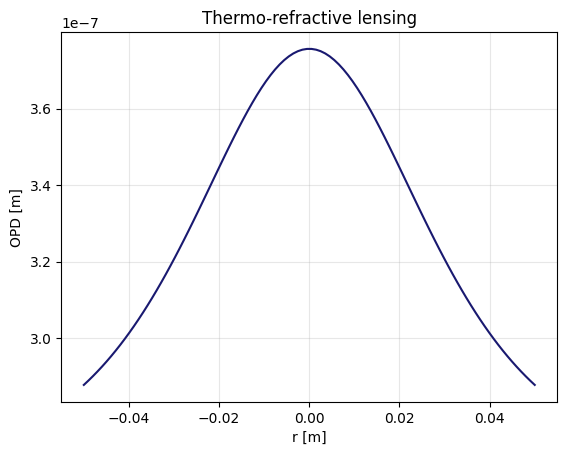

In [4]:
Z_coat_per_W, Z_bulk_per_W = hv.thermal_lenses_HG00(
    r, a, h, w, material
)

Z_coat = 0.1 * Z_coat_per_W
Z_bulk = 0.1 * Z_bulk_per_W

plt.plot(r, Z_coat, color = 'midnightblue')
plt.xlabel("r [m]")
plt.ylabel("OPD [m]")
plt.title('Thermo-refractive lensing')
plt.grid(alpha=0.3)
plt.savefig('thermo-refractive_lensing.png')
plt.show()

coating absorbtion

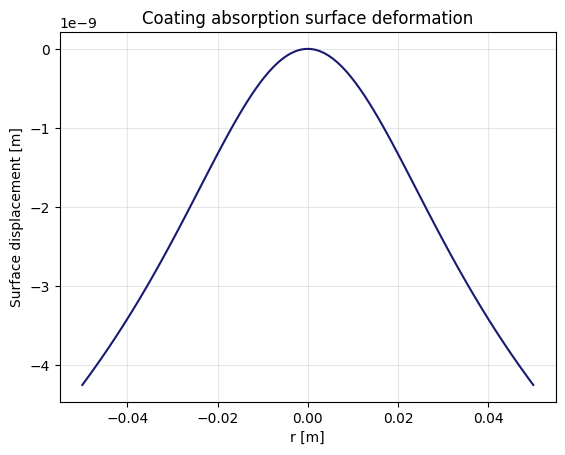

In [5]:
U_s_coat = hv.surface_deformation_coating_heating_HG00(r, a, h, w, material)
surface_displacement = 0.1 * U_s_coat * -0.51
#power is 0.1 W, change in refractive index is -0.51

plt.plot(r, surface_displacement, color = 'midnightblue')
plt.ylabel('Surface displacement [m]')
plt.xlabel("r [m]")
plt.title("Coating absorption surface deformation")
plt.grid(alpha=0.3)
plt.savefig('coating_absorbtion_thermal_deformation.png')

plt.show()

both

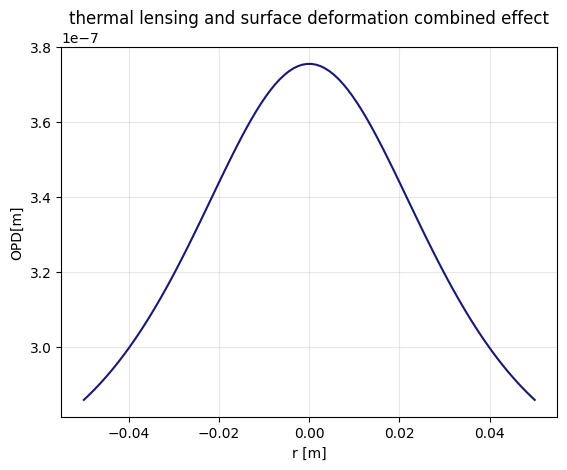

In [6]:
# displacement is in m but should be in effective distance. Multiply by the difference in refractive index
# recall that the refractive index of air is 1
surface_effective_distance = surface_displacement * (material.nr - 1)
overall_bump = Z_coat + surface_effective_distance

plt.plot(r, overall_bump, color = 'midnightblue')
plt.ylabel('OPD[m]')
plt.xlabel("r [m]")
plt.title("thermal lensing and surface deformation combined effect")
plt.grid(alpha=0.3)
plt.savefig('combined_effect.png')

plt.show()


file_path = os.getcwd()
np.save(os.path.join(file_path, 'hello_vinet_center_heater'), overall_bump)

## Ring heater

temperature of substrate

Text(0, 0.5, 'Depth [m]')

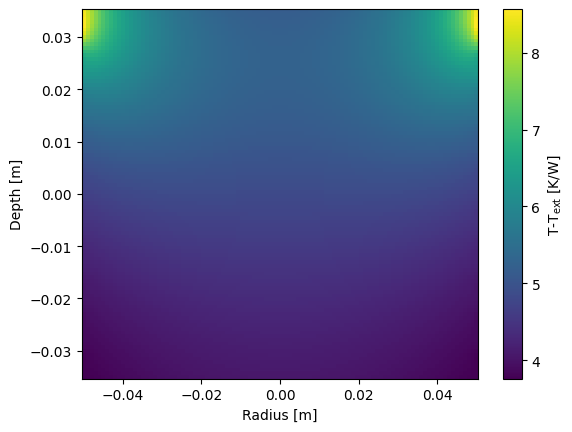

In [7]:
T_rh_per_W = ring_heater.substrate_temperature(r, z, a, b, c, h, material)

plt.pcolormesh(r, z, T_rh_per_W, rasterized=True, shading='auto')
plt.colorbar(label='T-$\mathrm{T}_{\mathrm{ext}}$ [K/W]')
plt.xlabel("Radius [m]")
plt.ylabel("Depth [m]")

OPD per watt

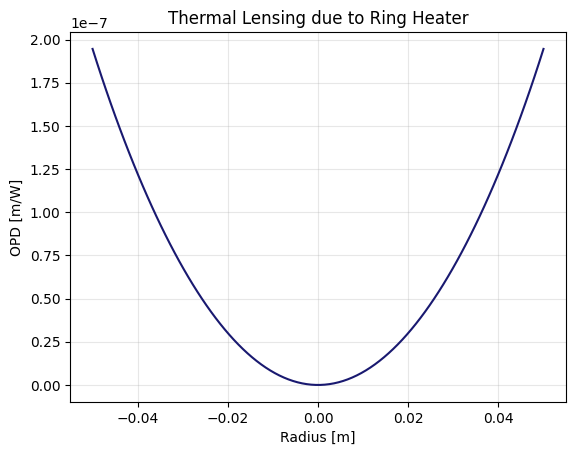

In [8]:
Z_rh_per_W = ring_heater.thermal_lens(r, a, b, c, h, material)
plt.plot(r, Z_rh_per_W, color = 'midnightblue')
plt.xlabel("Radius [m]")
plt.ylabel("OPD [m/W]")
plt.title('Thermal Lensing due to Ring Heater')
plt.grid(alpha = 0.3)
plt.show()

OPD assuming 0.5 W

Text(0, 0.5, 'OPD [m]')

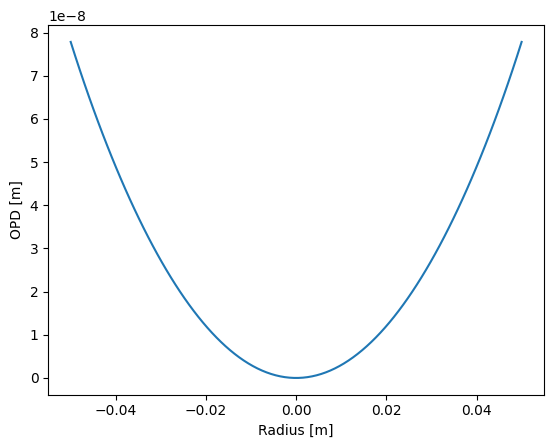

In [9]:
ring_opd = Z_rh_per_W * 0.4
plt.plot(r, ring_opd)
plt.xlabel("Radius [m]")
plt.ylabel("OPD [m]")

## ring and centre heaters

combined effect

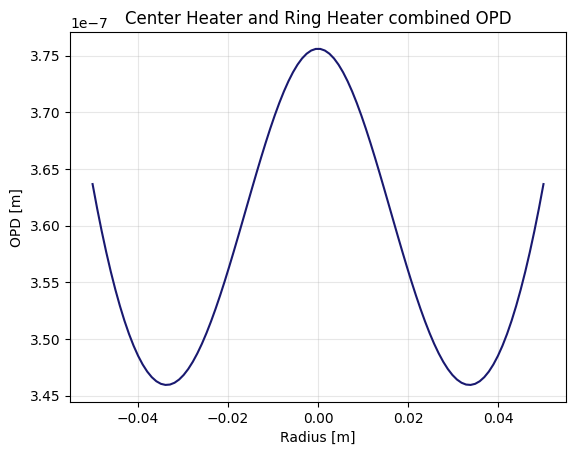

In [17]:
combined = ring_opd + overall_bump
plt.plot(r, combined, color = 'midnightblue')
plt.xlabel("Radius [m]")
plt.ylabel("OPD [m]")
plt.title('Center Heater and Ring Heater combined OPD')
plt.grid(alpha = 0.3)
plt.show()

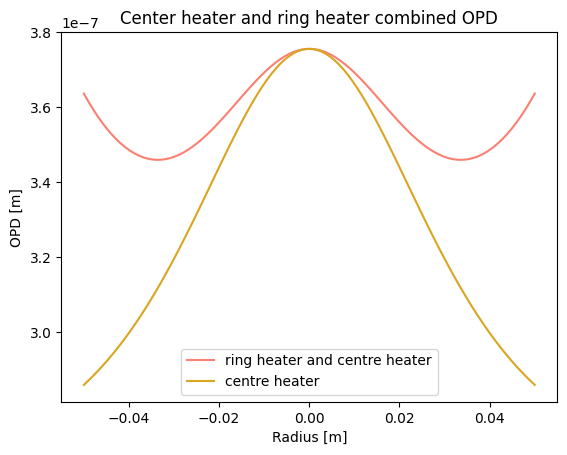

In [11]:
plt.plot(r, combined, color = 'salmon', label = 'ring heater and centre heater')
# plt.plot(r, ring_opd, color = 'goldenrod', label = 'ring heater')
plt.plot(r, overall_bump, color = 'goldenrod', label = 'centre heater')
plt.xlabel("Radius [m]")
plt.ylabel("OPD [m]")
plt.title('Center heater and ring heater combined OPD')
plt.legend()
plt.show()

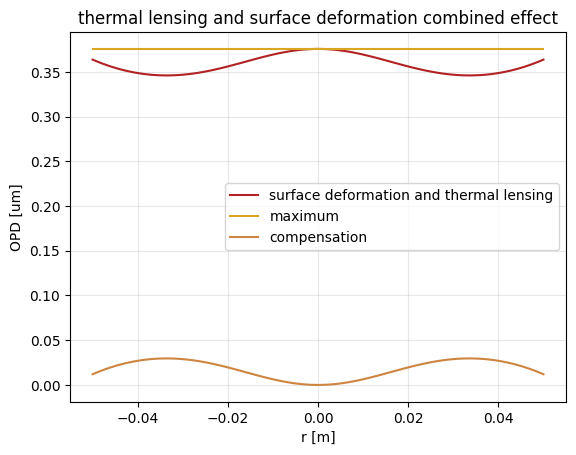

In [12]:
def its_a_line(x):
    a = int(np.shape(x)[0])
    y = np.zeros(a)
    for i in range(a):
        y[i] = np.max(combined) 
    return y

line = its_a_line(r)

compensation = line - combined

plt.plot(r, combined*1e6, label = 'surface deformation and thermal lensing', color = 'firebrick')
plt.plot(r, line*1e6, label = 'maximum', color = 'goldenrod')
plt.plot(r, compensation*1e6, label = 'compensation', color = 'peru')
plt.legend()
plt.ylabel('OPD [um]')
plt.xlabel("r [m]")
plt.title("thermal lensing and surface deformation combined effect")
plt.savefig('combined_effect_compensation.png')
plt.grid(alpha=0.3)
plt.show()

In [13]:
def two_gaussians(x_, mu, sigma, scale, offset):
    ''' Function for two 2D Gaussians symmetric about y axis with scale and vertcal offset
    mu = mean, location of maximum
    sigma = standard deviation
    scale = scale factor
    offset = vertical offset'''
    # scale must be positive, else gaussian can be flipped this is not physical
    scale = np.abs(scale)
    result = scale*((((1/sqrt(2*pi*sigma**2))*exp(-((x_-mu)**2)/(2*sigma**2)))) + (((1/sqrt(2*pi*sigma**2))*exp(-((x_+mu)**2)/(2*sigma**2))))) + offset
    return result

# fit to the compensation curve
p0 = (0.07, 0.02, 5.6e-9, 1.14e-7)
p0_gauss, _ = scipy.optimize.curve_fit(two_gaussians, r, compensation, p0)
print(*p0_gauss)

print('width of the idealised compensation =', p0_gauss[1]*10**3, 'mm')

0.03401597967157272 0.021921390064592528 3.983529428094896e-09 -4.321244788980967e-08
width of the idealised compensation = 21.92139006459253 mm


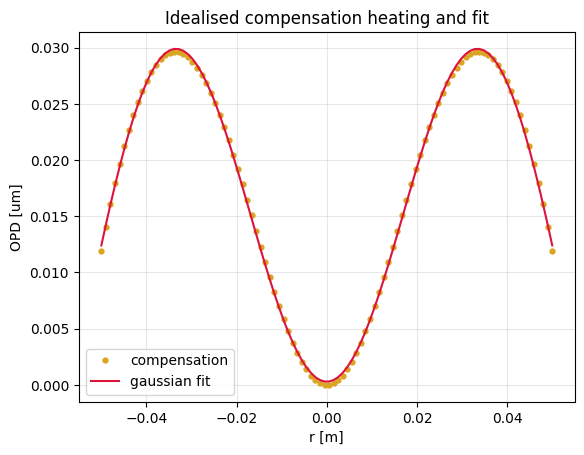

In [14]:
plt.plot(r, compensation*1e6, '.', markersize = 7, label = 'compensation', color = 'goldenrod')
plt.plot(r, two_gaussians(r, *p0_gauss)*1e6, label = 'gaussian fit', color = 'crimson')

plt.legend()
plt.title('Idealised compensation heating and fit')
plt.ylabel('OPD [um]')
plt.xlabel("r [m]")
plt.savefig('fit_to_compensation.png')
plt.grid(alpha=0.3)
plt.show()

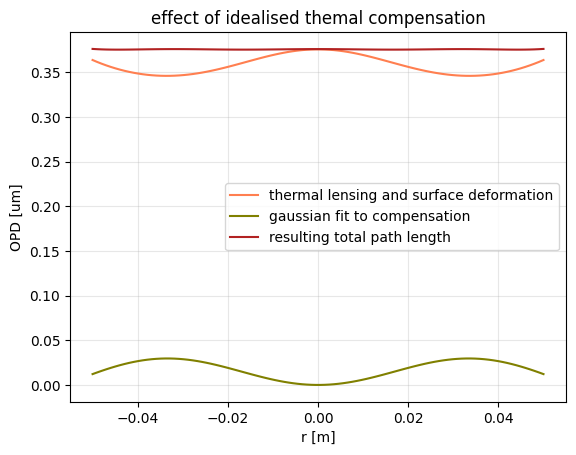

width of compensation gaussian = 0.06803195934314545 m
or 68.03195934314545 mm
magnitude of thermal deformation of compensation = 2.9579720962036987e-08
0.021921390064592528


In [15]:
temp_overall = combined + two_gaussians(r, *p0_gauss)

plt.plot(r, combined*1e6, label = 'thermal lensing and surface deformation', color = 'coral')
plt.plot(r, two_gaussians(r, *p0_gauss)*1e6, label = 'gaussian fit to compensation', color = 'olive')
plt.plot(r, temp_overall*1e6, label = 'resulting total path length', color = 'firebrick')
plt.ylabel('OPD [um]')
plt.xlabel("r [m]")
plt.title('effect of idealised themal compensation')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('effect_of_thermal_compensation.png')
plt.show()

print('width of compensation gaussian =', 2*p0_gauss[0], 'm')
print('or', (2*p0_gauss[0])*10**3, 'mm')
print('magnitude of thermal deformation of compensation =', np.max(two_gaussians(r, *p0_gauss)) - np.min(two_gaussians(r, *p0_gauss)))
print(p0_gauss[1])

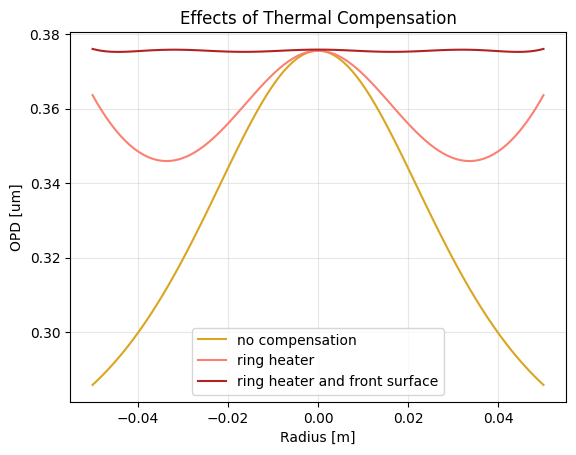

In [16]:
plt.plot(r, overall_bump*1e6, color = 'goldenrod', label = 'no compensation')
plt.plot(r, combined*1e6, color = 'salmon', label = 'ring heater')
plt.plot(r, temp_overall*1e6,  color = 'firebrick', label = 'ring heater and front surface')
plt.xlabel("Radius [m]")
plt.ylabel("OPD [um]")
plt.title('Effects of Thermal Compensation')
plt.legend()
plt.grid(alpha = 0.3)
plt.show()